In [206]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

pd.options.display.max_columns = None

In [207]:
gl_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-Game-Log.csv')
gl_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Game-Log.csv')
gl_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Game-Log.csv')
gl_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Game-log.csv')
gl_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Game-Log.csv')

team_opp_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-PerGameTeamAndOpponentStats.csv')
team_opp_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Team&Opponent-Per-Game.csv')
team_opp_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Team&Opp-Per-Game.csv')
team_opp_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Team&Opponents.csv')
team_opp_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Team&Opp-Per-Game.csv')

roster_19_20 = pd.read_csv('Clean Datasets/Clean-19-20-roster.csv')
roster_20_21 = pd.read_csv('Clean Datasets/Clean-20-21-Roster.csv')
roster_21_22 = pd.read_csv('Clean Datasets/Clean-21-22-Roster.csv')
roster_22_23 = pd.read_csv('Clean Datasets/Clean-22-23-Roster.csv')
roster_23_24 = pd.read_csv('Clean Datasets/Clean-23-24-Roster.csv')

In [208]:
all_gl = pd.concat([gl_19_20, gl_20_21, gl_21_22, gl_22_23, gl_23_24], ignore_index=True)
all_gl = all_gl.drop(columns=['Unnamed: 0', 'G', 'OT', 'Streak'])
all_gl

,Date,Time,Type,Opponent,Rank,Ranked Match,Conf,SRS,Result,PF,PA,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF.1,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
0,2019-11-05,8:00p,REG,Nicholls State,NaN,False,Southland,-3.87,W,78,70,1,0,True,1.0,0.0,27,61,0.443,5,19,0.263,19,29,0.655,17,50,12,6,2,22,17,27,66,0.409,8,20,0.400,8,9,0.889,3,18,13,11,4,16,29
1,2019-11-08,9:00p,REG,Grand Canyon,NaN,False,WAC,-6.32,W,83,71,2,0,False,2.0,0.0,29,64,0.453,4,13,0.308,21,30,0.700,16,46,13,5,0,17,21,27,61,0.443,8,19,0.421,9,16,0.563,6,23,12,4,0,11,23
2,2019-11-10,9:00p,REG,Arizona,21.0,True,Pac-12,19.49,L,69,90,2,1,False,0.0,1.0,25,53,0.472,5,16,0.313,14,20,0.700,6,25,10,4,2,22,22,34,61,0.557,7,16,0.438,15,22,0.682,10,32,20,14,3,16,23
3,2019-11-18,8:00p,REG,Hawaii,NaN,False,Big West,-1.27,W,66,53,3,1,True,1.0,0.0,23,54,0.426,5,12,0.417,15,23,0.652,10,43,14,3,3,15,8,24,64,0.375,3,22,0.136,2,3,0.667,4,25,9,7,2,9,18
4,2019-11-20,9:00p,REG,The Citadel,NaN,False,Southern,-13.82,W,85,57,4,1,True,2.0,0.0,33,68,0.485,3,18,0.167,16,21,0.762,21,53,17,4,4,13,13,21,74,0.284,10,38,0.263,5,7,0.714,15,27,10,8,2,11,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2024-01-05,3:30p,CTOURN,Wisconsin,NaN,False,Big Ten,16.01,W,93,87,26,8,False,4.0,0.0,26,61,0.426,8,19,0.421,18,21,0.857,11,25,15,5,3,10,19,27,60,0.450,9,19,0.474,20,25,0.800,16,40,18,5,4,12,17
162,2024-01-11,3:10p,NCAA,Morehead State,NaN,False,OVC,0.51,W,85,69,27,8,False,5.0,0.0,23,55,0.418,7,21,0.333,18,22,0.818,7,31,11,3,6,7,10,29,69,0.420,5,19,0.263,5,7,0.714,12,34,10,4,4,7,15
163,2024-01-14,8:40p,NCAA,Duquesne,NaN,False,A-10,7.35,W,89,63,28,8,False,6.0,0.0,21,64,0.328,6,22,0.273,19,24,0.792,10,35,8,5,3,8,14,30,65,0.462,4,17,0.235,12,17,0.706,10,37,14,4,6,7,15
164,2024-01-18,10:09p,NCAA,Iowa State,4.0,True,Big 12,22.30,W,72,69,29,8,False,7.0,0.0,30,62,0.484,6,18,0.333,22,30,0.733,13,38,12,9,4,6,13,30,63,0.476,3,13,0.231,10,12,0.833,7,25,10,1,0,9,18


In [209]:
# Rename duplicate column names to be more concise
all_gl.rename(columns={'PF': 'Points For', 'PA' : 'Points Against', 'PF.1' : 'PF'}, inplace=True)
all_gl

,Date,Time,Type,Opponent,Rank,Ranked Match,Conf,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
0,2019-11-05,8:00p,REG,Nicholls State,NaN,False,Southland,-3.87,W,78,70,1,0,True,1.0,0.0,27,61,0.443,5,19,0.263,19,29,0.655,17,50,12,6,2,22,17,27,66,0.409,8,20,0.400,8,9,0.889,3,18,13,11,4,16,29
1,2019-11-08,9:00p,REG,Grand Canyon,NaN,False,WAC,-6.32,W,83,71,2,0,False,2.0,0.0,29,64,0.453,4,13,0.308,21,30,0.700,16,46,13,5,0,17,21,27,61,0.443,8,19,0.421,9,16,0.563,6,23,12,4,0,11,23
2,2019-11-10,9:00p,REG,Arizona,21.0,True,Pac-12,19.49,L,69,90,2,1,False,0.0,1.0,25,53,0.472,5,16,0.313,14,20,0.700,6,25,10,4,2,22,22,34,61,0.557,7,16,0.438,15,22,0.682,10,32,20,14,3,16,23
3,2019-11-18,8:00p,REG,Hawaii,NaN,False,Big West,-1.27,W,66,53,3,1,True,1.0,0.0,23,54,0.426,5,12,0.417,15,23,0.652,10,43,14,3,3,15,8,24,64,0.375,3,22,0.136,2,3,0.667,4,25,9,7,2,9,18
4,2019-11-20,9:00p,REG,The Citadel,NaN,False,Southern,-13.82,W,85,57,4,1,True,2.0,0.0,33,68,0.485,3,18,0.167,16,21,0.762,21,53,17,4,4,13,13,21,74,0.284,10,38,0.263,5,7,0.714,15,27,10,8,2,11,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2024-01-05,3:30p,CTOURN,Wisconsin,NaN,False,Big Ten,16.01,W,93,87,26,8,False,4.0,0.0,26,61,0.426,8,19,0.421,18,21,0.857,11,25,15,5,3,10,19,27,60,0.450,9,19,0.474,20,25,0.800,16,40,18,5,4,12,17
162,2024-01-11,3:10p,NCAA,Morehead State,NaN,False,OVC,0.51,W,85,69,27,8,False,5.0,0.0,23,55,0.418,7,21,0.333,18,22,0.818,7,31,11,3,6,7,10,29,69,0.420,5,19,0.263,5,7,0.714,12,34,10,4,4,7,15
163,2024-01-14,8:40p,NCAA,Duquesne,NaN,False,A-10,7.35,W,89,63,28,8,False,6.0,0.0,21,64,0.328,6,22,0.273,19,24,0.792,10,35,8,5,3,8,14,30,65,0.462,4,17,0.235,12,17,0.706,10,37,14,4,6,7,15
164,2024-01-18,10:09p,NCAA,Iowa State,4.0,True,Big 12,22.30,W,72,69,29,8,False,7.0,0.0,30,62,0.484,6,18,0.333,22,30,0.733,13,38,12,9,4,6,13,30,63,0.476,3,13,0.231,10,12,0.833,7,25,10,1,0,9,18


In [210]:
all_gl.isna().sum()

Date                0
Time                0
Type                0
Opponent            0
Rank              120
Ranked Match        0
Conf                1
SRS                 1
Result              0
Points For          0
Points Against      0
W                   0
L                   0
Home Game           0
Win Streak         33
Lose Streak        33
FG                  0
FGA                 0
FG%                 0
3P                  0
3PA                 0
3P%                 0
FT                  0
FTA                 0
FT%                 0
ORB                 0
TRB                 0
AST                 0
STL                 0
BLK                 0
TOV                 0
PF                  0
OPP FG              0
OPP FGA             0
OPP FG%             0
OPP 3P              0
OPP 3PA             0
OPP 3P%             0
OPP FT              0
OPP FTA             0
OPP FT%             0
OPP ORB             0
OPP TRB             0
OPP AST             0
OPP STL             0
OPP BLK   

In [211]:
# Find the row with missing values
lindenwood = all_gl.loc[all_gl['Conf'].isna()]
lindenwood

,Date,Time,Type,Opponent,Rank,Ranked Match,Conf,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
6,2019-11-26,8:00p,REG,Lindenwood,NaN,False,NaN,NaN,W,117,65,6,1,True,4.0,0.0,39,63,0.619,11,25,0.44,28,37,0.757,10,39,25,13,4,14,13,25,64,0.391,11,30,0.367,4,5,0.8,7,22,10,10,0,24,30


In [212]:
# Fill in missing conference value
lindenwood['Conf'] = 'OVC'
lindenwood

,Date,Time,Type,Opponent,Rank,Ranked Match,Conf,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
6,2019-11-26,8:00p,REG,Lindenwood,NaN,False,OVC,NaN,W,117,65,6,1,True,4.0,0.0,39,63,0.619,11,25,0.44,28,37,0.757,10,39,25,13,4,14,13,25,64,0.391,11,30,0.367,4,5,0.8,7,22,10,10,0,24,30


In [213]:
# Fill in missing SRS value with an estimate
lindenwood['SRS'] = 42
lindenwood

,Date,Time,Type,Opponent,Rank,Ranked Match,Conf,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
6,2019-11-26,8:00p,REG,Lindenwood,NaN,False,OVC,42,W,117,65,6,1,True,4.0,0.0,39,63,0.619,11,25,0.44,28,37,0.757,10,39,25,13,4,14,13,25,64,0.391,11,30,0.367,4,5,0.8,7,22,10,10,0,24,30


In [214]:
all_gl.loc[all_gl['Conf'].isna()] = lindenwood

In [215]:
all_gl.isna().sum()

Date                0
Time                0
Type                0
Opponent            0
Rank              120
Ranked Match        0
Conf                0
SRS                 0
Result              0
Points For          0
Points Against      0
W                   0
L                   0
Home Game           0
Win Streak         33
Lose Streak        33
FG                  0
FGA                 0
FG%                 0
3P                  0
3PA                 0
3P%                 0
FT                  0
FTA                 0
FT%                 0
ORB                 0
TRB                 0
AST                 0
STL                 0
BLK                 0
TOV                 0
PF                  0
OPP FG              0
OPP FGA             0
OPP FG%             0
OPP 3P              0
OPP 3PA             0
OPP 3P%             0
OPP FT              0
OPP FTA             0
OPP FT%             0
OPP ORB             0
OPP TRB             0
OPP AST             0
OPP STL             0
OPP BLK   

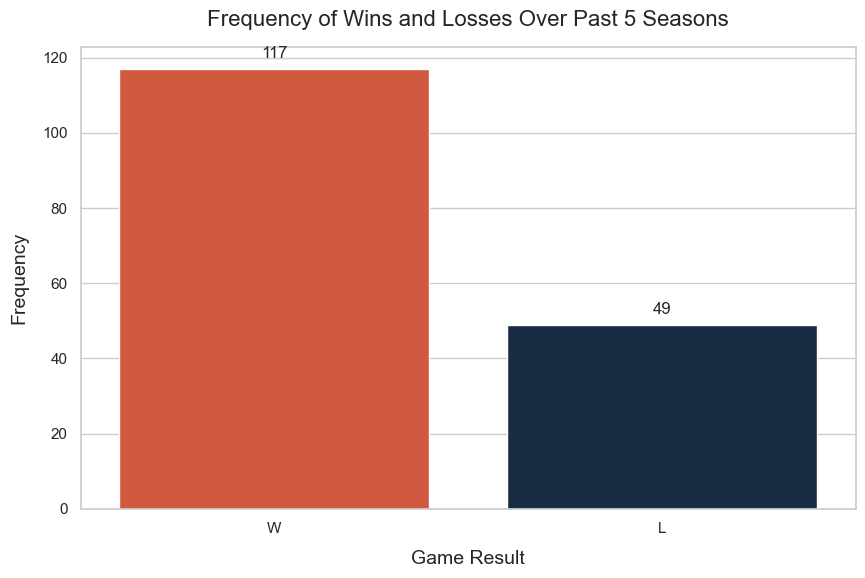

In [216]:
# Calculate the result counts
result_counts = all_gl['Result'].value_counts().reset_index()
result_counts.columns = ['Result', 'Frequency']

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

sns.barplot(data=result_counts, x='Result', y='Frequency', palette=['#E84A27', '#13294b'])

plt.xlabel('Game Result', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)
plt.title('Frequency of Wins and Losses Over Past 5 Seasons', fontsize=16, pad=15)

# Adding value annotations on top of the bars
for index, row in result_counts.iterrows():
    plt.text(row.name, row.Frequency + 2, row.Frequency, ha='center', va='bottom', fontsize=12)

plt.show()


In [217]:
# Make a numeric only game log data frame for our correlation matrix
num_gl = all_gl.copy()
num_gl['Result'] = num_gl['Result'].apply(lambda x: 1 if x == 'W' else 0)
num_gl['Ranked Match'] = num_gl['Ranked Match'].apply(lambda x: 1 if x == True else 0)
num_gl['Home Game'] = num_gl['Home Game'].apply(lambda x: 1 if x == True else 0)
num_gl['Type'] = num_gl['Type'].astype('category').cat.codes
num_gl['Conf'] = num_gl['Conf'].astype('category').cat.codes
num_gl = num_gl.drop(columns=['Date','Time','Rank','Opponent'])
num_gl

,Type,Ranked Match,Conf,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
0,2,0,21,-3.87,1,78,70,1,0,1,1.0,0.0,27,61,0.443,5,19,0.263,19,29,0.655,17,50,12,6,2,22,17,27,66,0.409,8,20,0.400,8,9,0.889,3,18,13,11,4,16,29
1,2,0,24,-6.32,1,83,71,2,0,0,2.0,0.0,29,64,0.453,4,13,0.308,21,30,0.700,16,46,13,5,0,17,21,27,61,0.443,8,19,0.421,9,16,0.563,6,23,12,4,0,11,23
2,2,1,16,19.49,0,69,90,2,1,0,0.0,1.0,25,53,0.472,5,16,0.313,14,20,0.700,6,25,10,4,2,22,22,34,61,0.557,7,16,0.438,15,22,0.682,10,32,20,14,3,16,23
3,2,0,7,-1.27,1,66,53,3,1,1,1.0,0.0,23,54,0.426,5,12,0.417,15,23,0.652,10,43,14,3,3,15,8,24,64,0.375,3,22,0.136,2,3,0.667,4,25,9,7,2,9,18
4,2,0,20,-13.82,1,85,57,4,1,1,2.0,0.0,33,68,0.485,3,18,0.167,16,21,0.762,21,53,17,4,4,13,13,21,74,0.284,10,38,0.263,5,7,0.714,15,27,10,8,2,11,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,0,0,6,16.01,1,93,87,26,8,0,4.0,0.0,26,61,0.426,8,19,0.421,18,21,0.857,11,25,15,5,3,10,19,27,60,0.450,9,19,0.474,20,25,0.800,16,40,18,5,4,12,17
162,1,0,15,0.51,1,85,69,27,8,0,5.0,0.0,23,55,0.418,7,21,0.333,18,22,0.818,7,31,11,3,6,7,10,29,69,0.420,5,19,0.263,5,7,0.714,12,34,10,4,4,7,15
163,1,0,0,7.35,1,89,63,28,8,0,6.0,0.0,21,64,0.328,6,22,0.273,19,24,0.792,10,35,8,5,3,8,14,30,65,0.462,4,17,0.235,12,17,0.706,10,37,14,4,6,7,15
164,1,1,3,22.30,1,72,69,29,8,0,7.0,0.0,30,62,0.484,6,18,0.333,22,30,0.733,13,38,12,9,4,6,13,30,63,0.476,3,13,0.231,10,12,0.833,7,25,10,1,0,9,18


In [218]:
# Create correlation matrix
gl_corr = num_gl.corr()
gl_corr

,Type,Ranked Match,Conf,SRS,Result,Points For,Points Against,W,L,Home Game,Win Streak,Lose Streak,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,OPP FG,OPP FGA,OPP FG%,OPP 3P,OPP 3PA,OPP 3P%,OPP FT,OPP FTA,OPP FT%,OPP ORB,OPP TRB,OPP AST,OPP STL,OPP BLK,OPP TOV,OPP PF
Type,1.000000,-0.030473,0.063755,-0.143599,0.017303,-0.013791,-0.122046,-0.505196,-0.378055,0.314180,-0.279709,0.060175,-0.026278,-0.019801,-0.004968,0.075497,0.107015,0.012197,-0.132161,-0.122136,-0.040119,0.003853,0.057074,-0.104227,-0.033579,0.009428,0.121214,0.009221,-0.102009,-0.039764,-0.081075,-0.019613,0.035311,-0.023185,-0.041117,-0.014437,-0.143995,-0.013960,-0.053442,-0.104331,0.049641,-0.015048,0.076969,-0.045986
Ranked Match,-0.030473,1.000000,-0.210393,0.494297,-0.307529,-0.215956,0.256143,0.132115,0.140660,-0.154066,-0.199100,0.259040,-0.111847,-0.098878,-0.053695,-0.024221,-0.063622,0.058443,-0.095936,-0.133440,0.053505,-0.237245,-0.276419,-0.129529,-0.016590,-0.139170,0.003965,0.231487,0.236536,0.003568,0.230974,0.195680,0.196681,0.061795,0.222718,0.209847,0.073223,0.191592,0.209267,0.336671,0.008429,0.036074,-0.071495,-0.143821
Conf,0.063755,-0.210393,1.000000,-0.544133,0.116823,0.213062,-0.204840,-0.384889,-0.365990,0.168556,-0.112977,-0.132106,0.181597,0.059481,0.162790,0.034688,0.076679,-0.087367,0.170722,0.232898,-0.052210,0.214734,0.232544,0.095488,0.204666,0.063254,0.340438,-0.063584,-0.156109,0.103235,-0.210905,-0.053509,0.077512,-0.112558,-0.098696,-0.095279,-0.075984,0.006091,-0.180549,-0.124995,0.265853,-0.122097,0.350028,0.298049
SRS,-0.143599,0.494297,-0.544133,1.000000,-0.368844,-0.360192,0.430328,0.402195,0.415786,-0.333310,-0.032621,0.306134,-0.368120,-0.192892,-0.284552,-0.147101,-0.126318,-0.030999,-0.004202,-0.077079,0.111942,-0.320031,-0.414009,-0.283359,-0.144274,-0.176202,-0.171348,0.190419,0.334399,-0.024953,0.340709,0.161204,0.005666,0.155047,0.228819,0.203914,0.122284,0.176437,0.321177,0.257056,-0.068390,0.130059,-0.240649,-0.095286
Result,0.017303,-0.307529,0.116823,-0.368844,1.000000,0.404264,-0.488643,-0.028972,-0.205387,0.295989,0.629713,-0.859043,0.353430,-0.015423,0.420372,0.053406,-0.115719,0.186786,0.235833,0.258117,-0.006880,0.037808,0.360312,0.297493,-0.066848,0.114587,-0.046704,-0.241891,-0.317650,0.234166,-0.471648,-0.132209,0.079264,-0.231392,-0.386908,-0.357548,-0.145007,-0.114162,-0.255935,-0.219161,-0.139569,-0.156929,0.043027,0.188236
Points For,-0.013791,-0.215956,0.213062,-0.360192,0.404264,1.000000,0.202072,-0.151105,-0.294883,0.169752,0.233766,-0.376794,0.830228,0.434484,0.681334,0.461415,0.140516,0.473274,0.388018,0.346005,0.161610,0.227877,0.318563,0.550373,0.132113,0.025269,0.035976,0.028807,0.110229,0.328427,-0.077243,0.152006,0.145008,0.093108,0.017859,0.033525,0.012343,-0.055958,-0.345906,0.086074,-0.040553,-0.104430,0.204789,0.250010
Points Against,-0.122046,0.256143,-0.204840,0.430328,-0.488643,0.202072,1.000000,0.221999,0.238702,-0.300862,-0.247035,0.342858,0.078536,0.157368,0.008687,0.114539,0.054451,0.138369,0.143474,0.078997,0.147280,-0.050866,-0.328654,-0.097995,-0.094741,-0.195698,-0.032760,0.296497,0.727843,0.155699,0.647155,0.364277,0.052548,0.417564,0.466314,0.423270,0.240170,0.152394,0.150290,0.472035,0.073217,0.146762,-0.186455,0.051843
W,-0.505196,0.132115,-0.384889,0.402195,-0.028972,-0.151105,0.221999,1.000000,0.893165,-0.291919,0.244731,-0.010312,-0.165884,-0.066474,-0.155102,-0.161981,-0.083270,-0.107362,0.046380,-0.002707,0.096966,-0.149512,-0.225819,-0.184218,-0.080426,-0.048973,-0.379904,-0.060555,0.156172,-0.006126,0.162725,-0.051255,-0.121482,0.015850,0.057474,0.011708,0.141609,0.056620,0.192419,0.065700,-0.227133,0.072446,-0.252197,-0.159229
L,-0.378055,0.140660,-0.365990,0.415786,-0.205387,-0.294883,0.238702,0.893165,1.000000,-0.261052,0.014756,0.172278,-0.293336,-0.117587,-0.270865,-0.204651,-0.066409,-0.186510,-0.034455,-0.065211,0.055234,-0.168108,-0.301966,-0.269421,-0.027094,-0.023907,-0.343723,0.040774,0.164402,-0.105966,0.233143,-0.025959,-0.134807,0.

In [219]:
# The variables that have the most affect on the Result column in order
result_corr = gl_corr['Result'].drop('Result')
result_corr = result_corr.abs().sort_values(ascending=False)
result_corr = result_corr.reset_index()
result_corr.columns = ['Variable', 'Correlation with Result']
result_corr


,Variable,Correlation with Result
0,Lose Streak,0.859043
1,Win Streak,0.629713
2,Points Against,0.488643
3,OPP FG%,0.471648
4,FG%,0.420372
5,Points For,0.404264
6,OPP FT,0.386908
7,SRS,0.368844
8,TRB,0.360312
9,OPP FTA,0.357548


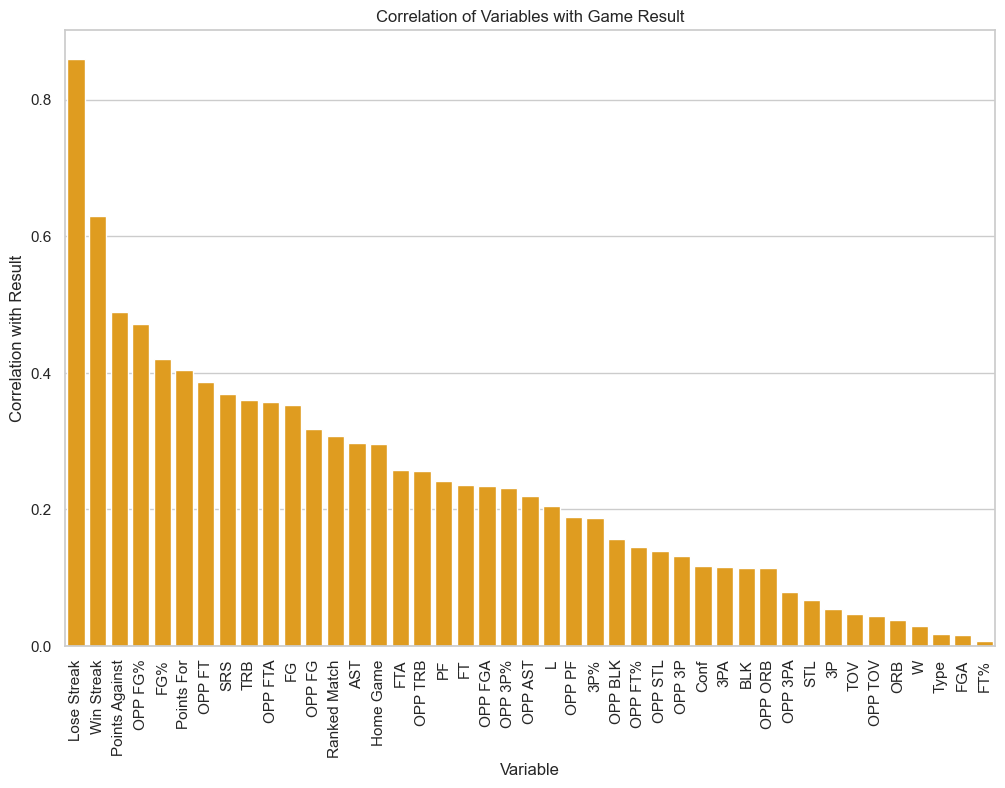

In [220]:
# Visualization to easily view what variables had the highest correlation with result
plt.figure(figsize=(12, 8))
sns.barplot(data=result_corr, x='Variable', y='Correlation with Result', color='orange')
plt.xticks(rotation=90)
plt.title('Correlation of Variables with Game Result')
plt.xlabel('Variable')
plt.ylabel('Correlation with Result')
plt.show()

In [221]:
# import warnings
# warnings.filterwarnings('ignore') #mutes warnings for 2021 and 2122 

# s1920 = ['19-20', '19-20', '19-20', '19-20', '19-20', '19-20', '19-20', 
#          '19-20', '19-20', '19-20' , '19-20', '19-20', '19-20', '19-20']
# roster_19_20['Season'] = s1920 # add season columns to rosters for analysis later

# s2021 = ['20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21'
#          '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21', '20-21']
# roster_20_21['Season'] = s2021
# roster_20_21['Season'][6] = '20-21'

# s2122 = ['21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22'
#          '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22', '21-22']
# roster_21_22['Season'] = s2122
# roster_21_22['Season'][6] = '21-22'


# s2223 = ['22-23', '22-23', '22-23', '22-23', '22-23',
#          '22-23', '22-23', '22-23', '22-23', '22-23', 
#          '22-23', '22-23', '22-23', '22-23', '22-23']
# roster_22_23['Season'] = s2223

# s2324 = ['23-24', '23-24', '23-24', '23-24', '23-24', '23-24',
#          '23-24', '23-24', '23-24', '23-24', '23-24', '23-24'
#          ,'23-24']
# roster_23_24['Season'] = s2324


# all_rosters = pd.concat([roster_19_20, roster_20_21, roster_21_22, roster_22_23, roster_23_24], ignore_index= True)
# count_players = all_rosters['Player'].value_counts()
# multiple_season = count_players[count_players > 1].index.to_list()
# attributes = ['Player', 'Season', 'PTS', 'REB', 'AST']
# roster_performance = all_rosters[all_rosters['Player'].isin(multiple_season)][attributes]
# roster_performance


In [222]:
# player_pts = roster_performance.pivot(index = 'Season', columns = 'Player', values = 'PTS')
# plt.figure(figsize = (15,15))
# player_pts
# for player in player_pts.columns :
#     plt.plot(player_pts.index, player_pts['Player'], marker = 'o', label = player)